# Analisi Acqua Potabile
In questo progetto, l'obbiettivo sarà quello di costruire un modello predittivo per determinare la potabilità dell'acqua in base alle sue caratteristiche chimiche.<br><br>
Nell'analisi dei dati, è risultato uno sbilanciamento della classe target, per cui è stato adottato lo *stratified sampling* per mantenere la distribuzione dei dati, e una bassa correlazione tra le features e la classe target.<br>
Sono stati testati diversi modelli di classificazione per l'individuazione del migliore utilizzando $2$ approcci, nel primo caso abbiamo utilizzato tutte le features a disposizione (Modello1), mentre nel secondo caso abbiamo utilizzato le $4$ migliori features individuate tramite il chi quadro test (Modello2), dopo aver ottimizzato gli iperparametri dei modelli tramite *GridSearchCV*, il *GradientBoostingClassifier* che utilizza quattro feature è emerso come il migliore.

## Table of Contents  
1. [Definizione delle Metriche](#4)
1. [Importazione delle Librerie](#1)      
1. [Caricamento Data](#2) 
1. [Data Analysis & Visualization](#3)      
    1. [Split in Training Set e Test Set e Bilanciamento](#3A) 
    2. [Gestione Valori Mancanti](#3B)
    3. [Outliers](#3C)
    4. [Standardizzazione](#3D)
    5. [Matrice di Correlazione](#3E)
    6. [Chi2](#3F)  
1. [Modello Dummy](#10)
1. [Modello1](#5)     
    1. [Selezione del Modello](#5A)     
    1. [Training e Test dei Modelli](#5B)     
1. [Modello2](#6)       
    1. [Selezione del Modello](#6A)    
    1. [Training e Test dei Modelli](#6B)
1. [Conclusione](#7)  

## Definizione delle Metriche<a class="anchor" id="4"></a>
Dato che il dataset risulta sbilanciato rispetto alla variabile target, non ci limiteremo ad utilizzare l'**accuracy** come unica metrica di valutazione. Considereremo anche la precision, la recall e l'F1-score.<br>
La **precision** rappresenta la percentuale di veri valori positivi individuati, rispetto al totale dei valori classificati come positivi. <span style='font-size:16px'>$\frac{TP}{TP+FP}$</span><br>
La **recall**, invece, ci dà la percentuale di valori positivi individuati, rispetto al totale dei valori positivi presenti.<span style='font-size:16px'>$\frac{TP}{TP+FN}$</span><br>
L'**F1-score**, infine, combina la precision e la recall, rappresentando la media armonica tra queste due misure. Il suo valore può variare tra 0 ed 1, e fornisce un'ulteriore valutazione della performance del modello, tenendo conto di entrambe le metriche.<span style='font-size:16px'>$\frac{TP}{TP+\frac{FN+FP}{2}}$</span>

## Importazione delle Librerie<a class="anchor" id="1"></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.ensemble import IsolationForest
from sklearn.feature_selection import chi2, SelectKBest
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.dummy import DummyClassifier

from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

## Caricamento Data<a class="anchor" id="2"></a>

In [2]:
water = pd.read_csv('water_potability.csv')

In [3]:
water.head()

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
0,NaN,204.890455,20791.318981,7.300212,368.516441,564.308654,10.379783,86.990970,2.963135,0
1,3.716080,129.422921,18630.057858,6.635246,NaN,592.885359,15.180013,56.329076,4.500656,0
2,8.099124,224.236259,19909.541732,9.275884,NaN,418.606213,16.868637,66.420093,3.055934,0
3,8.316766,214.373394,22018.417441,8.059332,356.886136,363.266516,18.436524,100.341674,4.628771,0
4,9.092223,181.101509,17978.986339,6.546600,310.135738,398.410813,11.558279,31.997993,4.075075,0


L'obiettivo del modello sarà quello di identficare se l'acqua è potabile o meno.
Il dataset è composto dalle seguenti features:
1. ph: pH of 1. water (0 to 14).
2. Hardness: Capacity of water to precipitate soap in mg/L.
3. Solids: Total dissolved solids in ppm.
4. Chloramines: Amount of Chloramines in ppm.
5. Sulfate: Amount of Sulfates dissolved in mg/L.
6. Conductivity: Electrical conductivity of water in μS/cm.
7. Organic_carbon: Amount of organic carbon in ppm.
8. Trihalomethanes: Amount of Trihalomethanes in μg/L.
9. Turbidity: Measure of light emiting property of water in NTU.
10. Potability: Indicates if water is safe for human consumption. 

## Data Analysis & Visualization<a class="anchor" id="3"></a>

In [4]:
# Controlla valori mancanti e il tipo di dato per features
water.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3276 entries, 0 to 3275
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ph               2785 non-null   float64
 1   Hardness         3276 non-null   float64
 2   Solids           3276 non-null   float64
 3   Chloramines      3276 non-null   float64
 4   Sulfate          2495 non-null   float64
 5   Conductivity     3276 non-null   float64
 6   Organic_carbon   3276 non-null   float64
 7   Trihalomethanes  3114 non-null   float64
 8   Turbidity        3276 non-null   float64
 9   Potability       3276 non-null   int64  
dtypes: float64(9), int64(1)
memory usage: 256.1 KB


In [5]:
# Dà informazioni statistiche sulle features numeriche
water.describe().T

,count,mean,std,min,25%,50%,75%,max
ph,2785.0,7.080795,1.594320,0.000000,6.093092,7.036752,8.062066,14.000000
Hardness,3276.0,196.369496,32.879761,47.432000,176.850538,196.967627,216.667456,323.124000
Solids,3276.0,22014.092526,8768.570828,320.942611,15666.690297,20927.833607,27332.762127,61227.196008
Chloramines,3276.0,7.122277,1.583085,0.352000,6.127421,7.130299,8.114887,13.127000
Sulfate,2495.0,333.775777,41.416840,129.000000,307.699498,333.073546,359.950170,481.030642
Conductivity,3276.0,426.205111,80.824064,181.483754,365.734414,421.884968,481.792304,753.342620
Organic_carbon,3276.0,14.284970,3.308162,2.200000,12.065801,14.218338,16.557652,28.300000
Trihalomethanes,3114.0,66.396293,16.175008,0.738000,55.844536,66.622485,77.337473,124.000000
Turbidity,3276.0,3.966786,0.780382,1.450000,3.439711,3.955028,4.500320,6.739000
Potability,3276.0,0.390110,0.487849,0.000000,0.000000,0.000000,1.000000,1.000000


In [6]:
# Controlla la presenza di valori mancanti
water.isnull().sum()

ph                 491
Hardness             0
Solids               0
Chloramines          0
Sulfate            781
Conductivity         0
Organic_carbon       0
Trihalomethanes    162
Turbidity            0
Potability           0
dtype: int64

array([[<Axes: title={'center': 'ph'}>,
        <Axes: title={'center': 'Hardness'}>,
        <Axes: title={'center': 'Solids'}>],
       [<Axes: title={'center': 'Chloramines'}>,
        <Axes: title={'center': 'Sulfate'}>,
        <Axes: title={'center': 'Conductivity'}>],
       [<Axes: title={'center': 'Organic_carbon'}>,
        <Axes: title={'center': 'Trihalomethanes'}>,
        <Axes: title={'center': 'Turbidity'}>],
       [<Axes: title={'center': 'Potability'}>, <Axes: >, <Axes: >]],
      dtype=object)

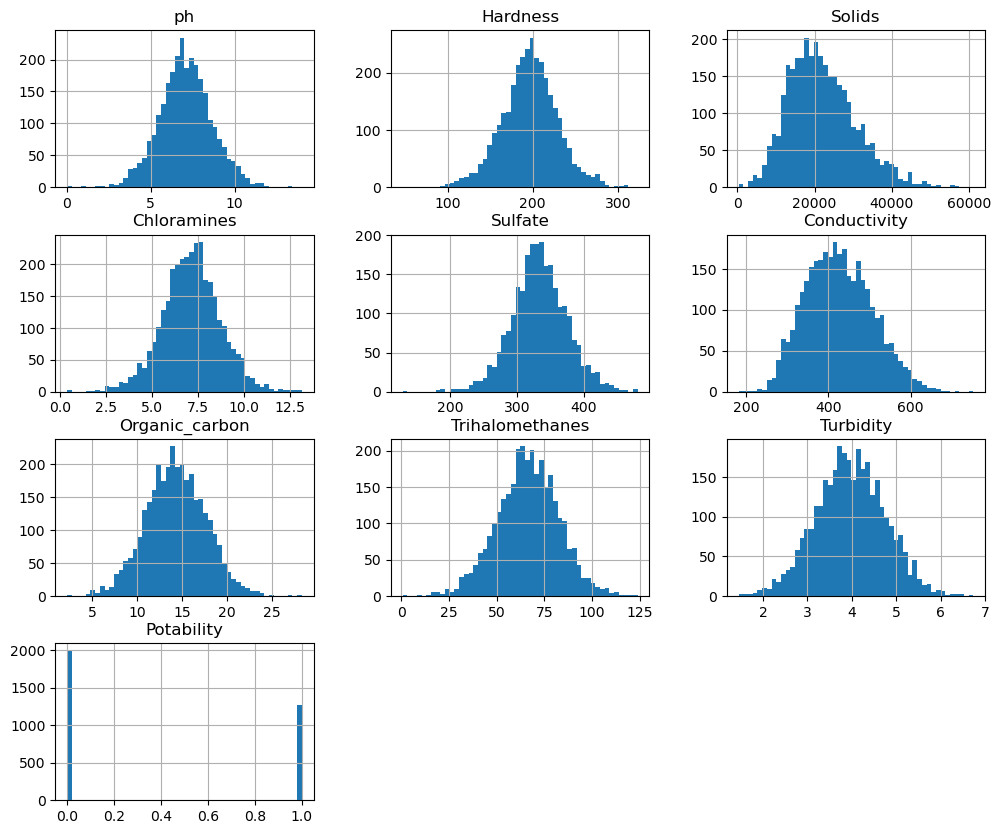

In [7]:
# Visualizza distribuzione features
water.hist(bins=50, figsize=(12,10))

### Split in Training Set e Test Set e Bilanciamento<a class="anchor" id="3A"></a>

<Axes: >

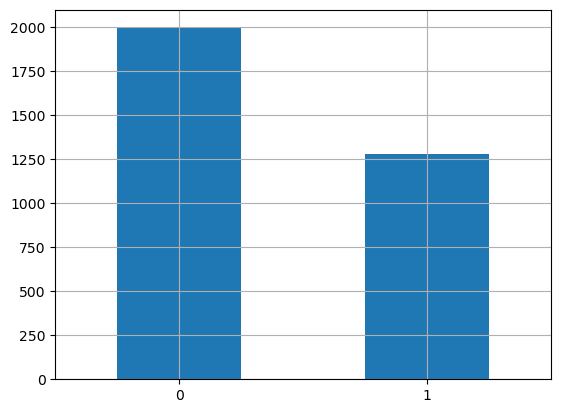

In [8]:
# Visualizza la colonna target per verificare lo sbilanciamento
water['Potability'].value_counts().plot.bar(rot=0, grid=True)

In [9]:
# Definiamo gli attributi dipendenti e indipendenti
X = water.drop('Potability', axis=1)
y = water['Potability']

In [10]:
SEED = 110

In [11]:
# Divido in train e test, uso il parametro stratify per mantenere la distribuzione
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=SEED, stratify=y)

In [12]:
print(X_train.shape, y_train.shape)

(2194, 9) (2194,)


Il dataset presenta uno **sbilanciamento** tra le etichette di classe, il che può compromettere l'efficacia del modello, soprattutto se si utilizza un campionamento casuale (random sampling). Per ovviare a questo problema, conviene utilizzare uno **stratified sampling** che consideri la distribuzione delle etichette di classe. In questo modo, si assicura che il campione di dati utilizzato per il training e la valutazione del modello mantenga la stessa proporzione di etichette di classe presenti nel dataset originale. Per utilizzare lo stratified sampling con la funzione *train_test_split*, è possibile utilizzare il parametro *stratify*.

### Gestione Valori Mancanti<a class="anchor" id="3B"></a>

In [13]:
# Creazione di un oggetto SimpleImputer con strategia "median"
imputer = SimpleImputer(strategy="median")

In [14]:
# Sostituisce i valori mancanti in X_train con la media dei valori di X_train rispetto ad ogni colonna
X_train = imputer.fit_transform(X_train)

In [15]:
X_train.shape

(2194, 9)

In [16]:
# Sostituisce i valori mancanti in X_test con la media dei valori di X_train rispetto ad ogni colonna
X_test = imputer.transform(X_test)

Dato che alcune colonne presentano dei valori mancanti, l'**imputazione** dei dati è il metodo preferito per gestire questo problema. L'eliminazione delle righe o delle colonne che contengono valori mancanti potrebbe comportare la perdita di troppi dati, compromettendo la qualità e la quantità dei dati a disposizione. Analizzando la distribuzione dei dati, risulta che l'imputazione è il metodo più efficace per gestire i valori mancanti in quanto consente di mantenere la distribuzione originale dei dati ed evita una eccessiva riduzione delle dimensioni del dataset.

### Outliers<a class="anchor" id="3C"></a>

In [17]:
# Converte la colonna 'Potability' in stringa
water['Potability'] = water['Potability'].astype(str)

<Axes: xlabel='Turbidity', ylabel='Potability'>

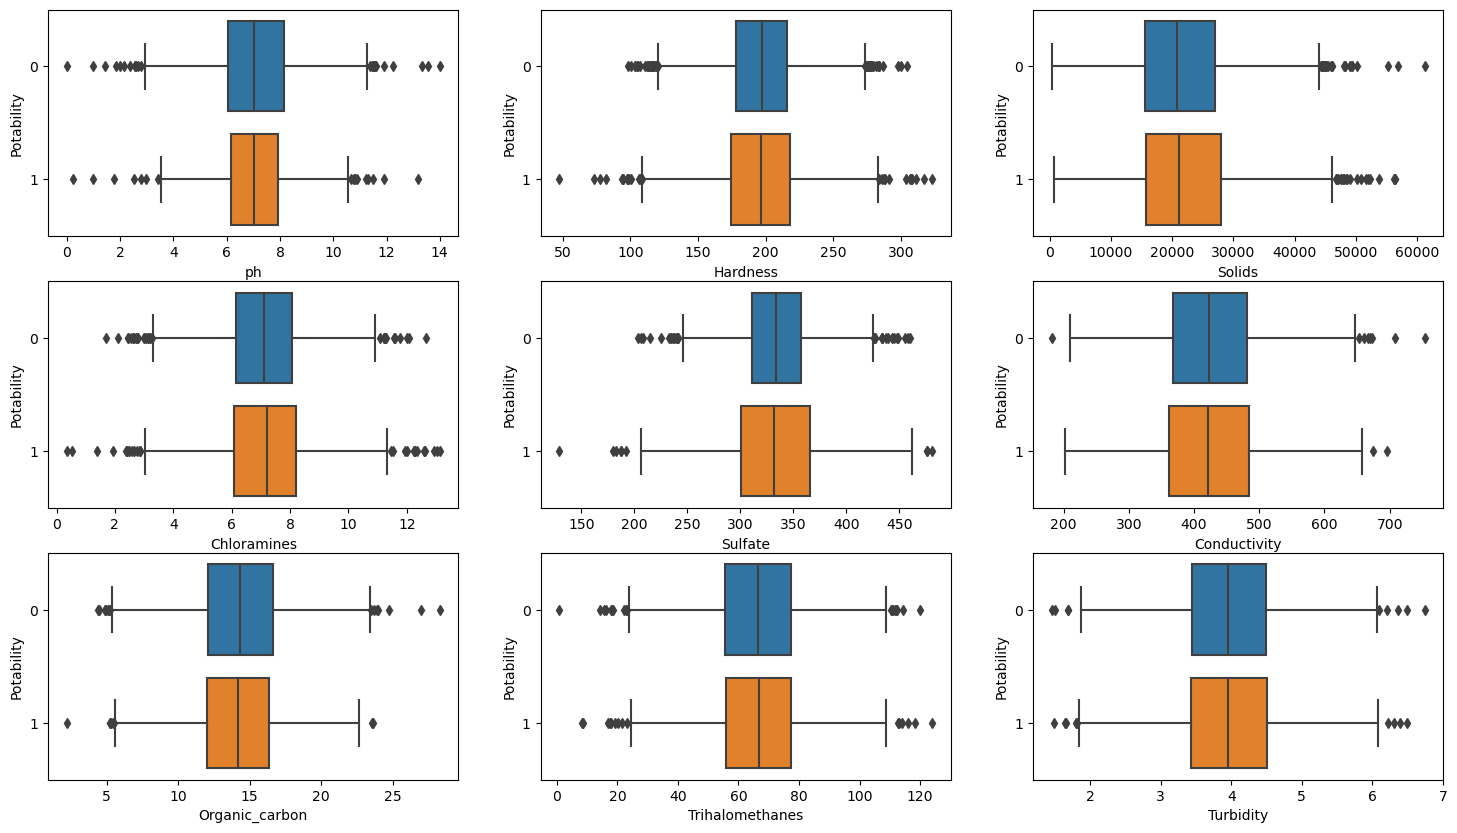

In [18]:
# Visualizza i grafici boxplot per evidenziare presenza di outliers
fig, axes = plt.subplots(3, 3, figsize=(18, 10))

sns.boxplot(ax=axes[0, 0], data=water, x="ph", y="Potability")
sns.boxplot(ax=axes[0, 1], data=water, x="Hardness", y="Potability")
sns.boxplot(ax=axes[0, 2], data=water, x="Solids", y="Potability")
sns.boxplot(ax=axes[1, 0], data=water, x="Chloramines", y="Potability")
sns.boxplot(ax=axes[1, 1], data=water, x="Sulfate", y="Potability")
sns.boxplot(ax=axes[1, 2], data=water, x="Conductivity", y="Potability")
sns.boxplot(ax=axes[2, 0], data=water, x="Organic_carbon", y="Potability")
sns.boxplot(ax=axes[2, 1], data=water, x="Trihalomethanes", y="Potability")
sns.boxplot(ax=axes[2, 2], data=water, x="Turbidity", y="Potability")

In [19]:
# Creazione di un oggetto IsolationForest con contaminazione 0.1
iso = IsolationForest(contamination=0.1)

In [20]:
# Viene addestrato è fatta una previsione su X_train, ed otteniamo un array dove 1 rappresenta un valore normale -1 un outliers
outliers = iso.fit_predict(X_train)

In [21]:
# Il calcolo ci permette di ottenere la percentuale di outliers nel dataset
percentuale_outliers = sum(outliers == -1)/len(X_train) * 100

In [22]:
print(f'{percentuale_outliers}%')

10.027347310847768%


Dai grafici boxplot notiamo la presenza di diversi outliers per ogni features, ragionevolmente bilanciati tra le due classi. Utilizzando l'algoritmo *IsolationForest* notiamo che nel dataset abbiamo circa il $10$% di outliers. 

### Standardizzazione<a class="anchor" id="3D"></a>

In [23]:
# Standardizzazione dei dati
scaler = StandardScaler()
X_train_stan = scaler.fit_transform(X_train)
X_test_stan = scaler.transform(X_test)

### Matrice di Correlazione<a class="anchor" id="3E"></a>

In [24]:
water['Potability'] = water['Potability'].astype(int)

In [64]:
# Crea la matrice di correlazione
corr_mat = water.corr()

<Axes: >

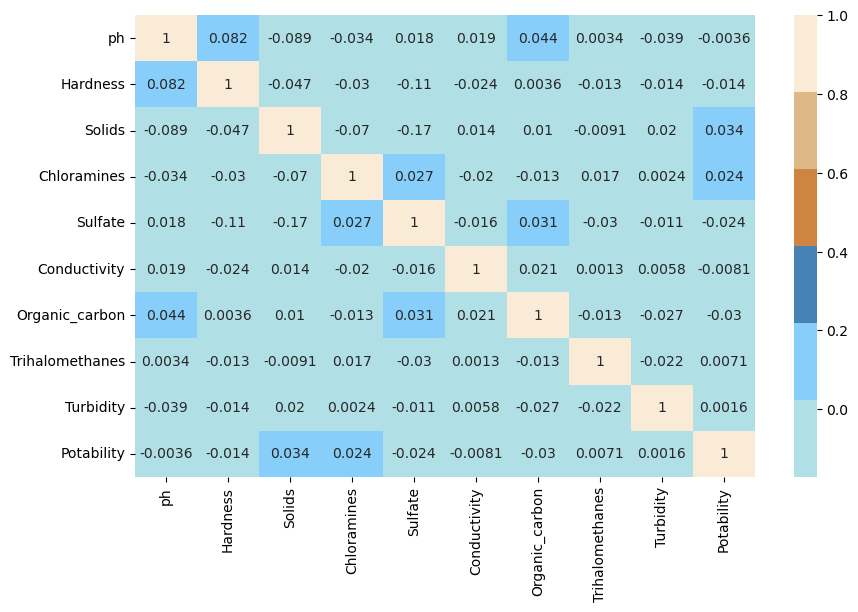

In [26]:
# Visualizza la matrice di correlazione come heatmap
cols = (["#B0E0E6", "#87CEFA", "#4682B4", "#CD853F", "#DEB887", "#FAEBD7"])
fig, ax = plt.subplots(figsize=(10, 6))
sns.heatmap(corr_mat, cmap=cols ,annot=True)

In [27]:
corr_mat["Potability"].sort_values(ascending=False)

Potability         1.000000
Solids             0.033743
Chloramines        0.023779
Trihalomethanes    0.007130
Turbidity          0.001581
ph                -0.003556
Conductivity      -0.008128
Hardness          -0.013837
Sulfate           -0.023577
Organic_carbon    -0.030001
Name: Potability, dtype: float64

Dalla *matrice di correlazione* notiamo che le variabili **non sono correlate** tra di loro o con la variabile **Potability**, in particolare **Solids**, **Chloramines**, **Sulfate**, **Organic_carbon** presentano una migliore correlazione rispetto variabile **Potability** ma comunque risulta bassa.

### Chi2<a class="anchor" id="3F"></a>

In [28]:
# Uso per la normalizzazione dei dati MinMaxScaler, in quanto chi2 richiede una matrice X di soli valori positivi
scaler = MinMaxScaler()
X_train_minMax = scaler.fit_transform(X_train)

In [29]:
# Chi-square test delle feature rispetto alla variabile target
chi2_test, p_values = chi2(X_train_minMax, y_train)

In [30]:
chi2_test

array([4.06164095e-03, 4.72661833e-03, 3.01785778e-01, 2.58275334e-04,
       2.47262047e-02, 7.66232083e-05, 8.64904595e-03, 1.31713630e-02,
       6.14188775e-02])

In [31]:
p_values

array([0.94918442, 0.94518829, 0.58276506, 0.98717779, 0.87505123,
       0.99301583, 0.92590336, 0.90863016, 0.80426724])

Viene eseguito il *Chi-sqaure test* per valutare l'ipotesi nulla cioè che le features e la variabile target sia indipendenti tra di loro. Nel caso i valori di p_values siano inferiori ad un valore soglia (0.05) l'ipotesi viene rifiutata ed indica che vi è una relazione tra la feature e la variabile target, nel nostro caso **nessun valore** si trova al di sotto di tale soglia quindi non possiamo rifiutare l'ipotesi.

## Modello Dummy<a class="anchor" id="10"></a>

In [32]:
# Crea classificatore dummy con startegia uniform
clf_dummy_uniform = DummyClassifier(strategy='uniform',random_state=SEED)

In [33]:
# Addestramento e predizione del modello
clf_dummy_uniform.fit(X_train, y_train)
y_pred = clf_dummy_uniform.predict(X_test)

In [34]:
print(accuracy_score(y_test, y_pred))

0.5073937153419593


In [35]:
# Crea classificatore dummy con startegia most_frequent
clf_dummy_most_fre = DummyClassifier(strategy='most_frequent', random_state=SEED)

In [36]:
# Addestramento e predizione del modello
clf_dummy_most_fre.fit(X_train, y_train)
y_pred = clf_dummy_most_fre.predict(X_test)

In [37]:
print(accuracy_score(y_test, y_pred))

0.609981515711645


Utilizziamo il modello *Dummy* come modello randomico per stabilire un livello base di prestazioni, nello specifico vengono utilizzate due varianti del modello,<br>
Il primo modello utilizza la strategia *uniform*, che ha la propabilità del $50$% di prevedere una o l'altra classe.<br>
Il secondo modello utilizza la startegia *most_frequent*, che prevede sempre la classe maggioritaria.

## Modello1<a class="anchor" id="5"></a>
Utilizzo di tutte le features.

### Selezione dei Modelli<a class="anchor" id="5A"></a>

In [38]:
# Definizione dei modelli
models = [
    ('Logistic Regression', LogisticRegression()),
    ('RandomForest', RandomForestClassifier()),
    ('K-nearest neighbors', KNeighborsClassifier()),
    ('Decision Tree', DecisionTreeClassifier()),
    ('Gradient Boosting', GradientBoostingClassifier())
]

In [39]:
results = []
names = []

# Definiamo un oggetto StratifiedKFold con 10 fold
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=SEED)

# Resettiamo gli indici di y_train per utilizzare gli indici ottenuti da kfold
y_train = pd.Series(y_train).reset_index(drop=True)

# Iteriamo sui modelli
for name, model in models:
    # Per ogni modello, effettuiamo la cross-validation utilizzando StratifiedKFold
    fold_results = []
    for train_idx, val_idx in kfold.split(X_train_stan, y_train):
        
        # Otteniamo i dati di train e di validation
        X_train_fold, y_train_fold = X_train_stan[train_idx], y_train[train_idx]
        X_val_fold, y_val_fold = X_train_stan[val_idx], y_train[val_idx]
        
        # Addestramento e valutazione del modello
        model.fit(X_train_fold, y_train_fold)
        y_pred = model.predict(X_val_fold)
        fold_results.append(accuracy_score(y_val_fold, y_pred))
    
    # Calcoliamo la media delle accuracy ottenute nei vari fold
    mean_acc = np.mean(fold_results)
    results.append(mean_acc)
    names.append(name)
    print(f'{name}: {mean_acc:.3f}')

Logistic Regression: 0.610
RandomForest: 0.670
K-nearest neighbors: 0.636
Decision Tree: 0.612
Gradient Boosting: 0.649


Tra i $5$ modelli testati i $2$ che hanno avuto una migliore performance sono stati il *RandomForest* e il *GradientBoosting* sui quali effettueremo il tuning degli iperparametri.

### Training e Test dei Modelli<a class="anchor" id="5A"></a>

In [40]:
# Definisce i parametri da testare per RandomForest
rf_params = {
    'n_estimators': [50, 100],
    'max_features': [1,2,3,4],
    'min_samples_split': [0.01, 0.05, 0.1],
    'min_samples_leaf': [0.01, 0.05, 0.1]
}

# Definisce i parametri da testare per GradientBoosting
gb_params = {
    'n_estimators': [50, 100],
    "learning_rate": [0.01, 0.1, 0.25, 0.5, 0.75, 1],
    'max_features': [1,2,3,4],
    'min_samples_split': [0.01, 0.05, 0.1],
    'min_samples_leaf': [0.01, 0.05, 0.1]
}

In [41]:
# Crea gli estimatori per Random Forest e GradientBoosting
rf = RandomForestClassifier()
gb = GradientBoostingClassifier()

# Esegui la ricerca dei migliori iperparametri per Random Forest
rf_grid = GridSearchCV(rf, rf_params)
rf_grid.fit(X_train_stan, y_train)

# Esegui la ricerca dei migliori iperparametri per GradientBoosting
gb_grid = GridSearchCV(gb, gb_params)
gb_grid.fit(X_train_stan, y_train)

# Stampa i risultati della ricerca dei migliori iperparametri per Random Forest e GradientBoosting
print("Migliori iperparametri per RandomForest:", rf_grid.best_params_)
print("Migliori iperparametri per Gradient Boosting:", gb_grid.best_params_)

Migliori iperparametri per RandomForest: {'max_features': 4, 'min_samples_leaf': 0.01, 'min_samples_split': 0.01, 'n_estimators': 50}
Migliori iperparametri per Gradient Boosting: {'learning_rate': 0.25, 'max_features': 4, 'min_samples_leaf': 0.01, 'min_samples_split': 0.01, 'n_estimators': 100}


In [42]:
# Creo il modello con i migliori iperparametri
rf_model = RandomForestClassifier(max_features=4, min_samples_leaf=0.01,
                                  min_samples_split=0.01, n_estimators= 50,
                                  random_state=SEED)

gb_model = GradientBoostingClassifier(learning_rate=0.25, max_features=3,
                                      min_samples_leaf=0.05, min_samples_split=0.01,
                                      n_estimators=50, random_state=SEED)

In [43]:
rf_model.fit(X_train_stan, y_train)
gb_model.fit(X_train_stan, y_train)

GradientBoostingClassifier(learning_rate=0.25, max_features=3,
                           min_samples_leaf=0.05, min_samples_split=0.01,
                           n_estimators=50, random_state=110)

In [44]:
predict_rf = rf_model.predict(X_test_stan)
predict_gb = gb_model.predict(X_test_stan)

In [45]:
print('RandomForest', accuracy_score(y_test, predict_rf))
print('GradientBoosting', accuracy_score(y_test, predict_gb))

RandomForest 0.6608133086876156
GradientBoosting 0.6367837338262476


In [46]:
print('RandomForest\n',confusion_matrix(y_test,predict_rf))
print('GradientBoosting\n',confusion_matrix(y_test,predict_gb))

RandomForest
 [[610  50]
 [317 105]]
GradientBoosting
 [[561  99]
 [294 128]]


In [47]:
print('RandomForest\n',classification_report(y_test, predict_rf))

RandomForest
               precision    recall  f1-score   support

           0       0.66      0.92      0.77       660
           1       0.68      0.25      0.36       422

    accuracy                           0.66      1082
   macro avg       0.67      0.59      0.57      1082
weighted avg       0.67      0.66      0.61      1082



In [48]:
print('GradientBoosting\n',classification_report(y_test, predict_gb))

GradientBoosting
               precision    recall  f1-score   support

           0       0.66      0.85      0.74       660
           1       0.56      0.30      0.39       422

    accuracy                           0.64      1082
   macro avg       0.61      0.58      0.57      1082
weighted avg       0.62      0.64      0.61      1082



Tra i due modelli dove abbiamo utilizzato tutte le features, il *GradientBoosting* ha mostrato i risultati migliori complessivamente. Rispetto al *RandomForest*, il *GradientBoosting* ha ottenuto una prestazione superiore nella recall della classe 1 (potabile), dimostrando una maggiore capacità di individuare correttamente le istanze di acqua potabile.

## Modello2<a class="anchor" id="6"></a>
Utilizzo di 4 features.

### Selezione dei Modelli<a class="anchor" id="6A"></a>

In [49]:
select = SelectKBest(chi2, k=4)

In [50]:
# Crea una X_train seleziondo le migliori 4 features rispetto al chi-square test
X_train_chi2 = select.fit_transform(X_train_minMax, y_train)

In [51]:
mask = select.get_support()

In [52]:
mask

array([False, False,  True, False,  True, False, False,  True,  True])

In [53]:
# Stampa le features scelte
print(X.columns[mask])

Index(['Solids', 'Sulfate', 'Trihalomethanes', 'Turbidity'], dtype='object')


In [54]:
results = []
names = []

# Definiamo un oggetto StratifiedKFold con 10 fold
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=SEED)

# Resettiamo gli indici di y_train per utilizzare gli indici ottenuti da kfold
y_train = pd.Series(y_train).reset_index(drop=True)

# Iteriamo sui modelli
for name, model in models:
    # Per ogni modello, effettuiamo la cross-validation utilizzando StratifiedKFold
    fold_results = []
    for train_idx, val_idx in kfold.split(X_train_chi2, y_train):
        
        # Otteniamo i dati di train e di validation
        X_train_fold, y_train_fold = X_train_chi2[train_idx], y_train[train_idx]
        X_val_fold, y_val_fold = X_train_chi2[val_idx], y_train[val_idx]
        
        # Addestramento e valutazione del modello
        model.fit(X_train_fold, y_train_fold)
        y_pred = model.predict(X_val_fold)
        fold_results.append(accuracy_score(y_val_fold, y_pred))
    
    # Calcoliamo la media delle accuracy ottenute nei vari fold
    mean_acc = np.mean(fold_results)
    results.append(mean_acc)
    names.append(name)
    print(f'{name}: {mean_acc:.3f}')

Logistic Regression: 0.611
RandomForest: 0.604
K-nearest neighbors: 0.583
Decision Tree: 0.557
Gradient Boosting: 0.620


### Training e Test dei Modelli<a class="anchor" id="6B"></a>

In [55]:
# Definisci i parametri da testare per GradientBoosting
gb_params = {
    'n_estimators': [50, 100],
    "learning_rate": [0.01, 0.1, 0.25, 0.5, 0.75, 1],
    'max_features': [1,2],
    'min_samples_split': [0.01, 0.05, 0.1],
    'min_samples_leaf': [0.01, 0.05, 0.1]
}
# Definisci i parametri da testare per Logistic Regression
lr_params = {
    'C': [0.01, 0.1, 1, 10, 100],
    'solver': ['newton-cg', 'lbfgs', 'liblinear']
}

In [56]:
# Crea gli estimatori per GradientBoosting e Logistic Regression
gb2 = GradientBoostingClassifier()
lr2 = LogisticRegression()

# Esegui la ricerca dei migliori iperparametri per GradientBoosting
gb_grid2 = GridSearchCV(gb2, gb_params)
gb_grid2.fit(X_train_stan, y_train)

# Esegui la ricerca dei migliori iperparametri per Logistic Regression
lr_grid2 = GridSearchCV(lr2, lr_params)
lr_grid2.fit(X_train_stan, y_train)

# Stampa i risultati della ricerca dei migliori iperparametri per GradientBoosting e Logistic Regression
print("Migliori iperparametri per Gradient Boosting:", gb_grid2.best_params_)
print("Migliori iperparametri per Logistic Regression:", lr_grid2.best_params_)

Migliori iperparametri per Gradient Boosting: {'learning_rate': 0.25, 'max_features': 2, 'min_samples_leaf': 0.01, 'min_samples_split': 0.05, 'n_estimators': 100}
Migliori iperparametri per Logistic Regression: {'C': 0.01, 'solver': 'newton-cg'}


In [57]:
gb2_model = GradientBoostingClassifier(learning_rate=0.25, max_features=2,
                                       min_samples_leaf=0.01, min_samples_split=0.01,
                                       n_estimators=50, random_state=SEED)

lr2_model = LogisticRegression(C=0.01, solver='newton-cg', random_state=SEED)

In [58]:
gb2_model.fit(X_train_stan, y_train)
lr2_model.fit(X_train_stan, y_train)

LogisticRegression(C=0.01, random_state=110, solver='newton-cg')

In [59]:
predict_gb2 = gb2_model.predict(X_test_stan)
predict_lr2 = lr2_model.predict(X_test_stan)

In [60]:
print('GradientBoosting',accuracy_score(y_test, predict_gb2))
print('LogisticRegression',accuracy_score(y_test, predict_lr2))

GradientBoosting 0.6367837338262476
LogisticRegression 0.609981515711645


In [61]:
print('GradientBoosting\n',confusion_matrix(y_test,predict_gb2))
print('LogisticRegression\n',confusion_matrix(y_test,predict_lr2))

GradientBoosting
 [[570  90]
 [303 119]]
LogisticRegression
 [[660   0]
 [422   0]]


In [62]:
print('GradientBoosting\n',classification_report(y_test, predict_gb2))

GradientBoosting
               precision    recall  f1-score   support

           0       0.65      0.86      0.74       660
           1       0.57      0.28      0.38       422

    accuracy                           0.64      1082
   macro avg       0.61      0.57      0.56      1082
weighted avg       0.62      0.64      0.60      1082



In [63]:
print('LogisticRegression\n',classification_report(y_test, predict_lr2))

LogisticRegression
               precision    recall  f1-score   support

           0       0.61      1.00      0.76       660
           1       0.00      0.00      0.00       422

    accuracy                           0.61      1082
   macro avg       0.30      0.50      0.38      1082
weighted avg       0.37      0.61      0.46      1082



C:\Users\a3wse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\a3wse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\a3wse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Tra i due modelli in cui abbiamo utilizzato solo 4 features selezionate mediante il chi-Square test, il *GradientBoosting* ha ottenuto i migliori risultati. Inoltre, la *LogisitcRegression* non è stata in grado di individuare correttamente la classe 1 in nessuna delle istanze.

## Conclusione<a class="anchor" id="7"></a>
In conclusione, dopo aver testato quattro modelli, due con tutte le features e due con soltanto quattro features selezionate tramite il chi-square test, il modello *GradientBoosting* ha ottenuto le migliori prestazioni. Pertanto, abbiamo scelto di utilizzare il modello addestrato con le sole quattro features, in quanto risulta più efficiente dal punto di vista computazionale.<br><br>

Tuttavia, il modello ha comunque mostrato alcune problematiche nelle prestazioni, soprattutto nella recall della classe 1 (potabile). Questo suggerisce che il modello potrebbe non essere sempre in grado di individuare correttamente la classe, probabilmente a causa della bassa dipendenza tra le features.